# Projekt Autoenkoder
Indeks: 145317

Wymagania:
- stworzenie sieci neuronowej typu autoencoder
- dane wejściowe to obrazy czarno-białe (1 kanał)
- dane wyjściowe to obrazy kolorowe (3 kanały)
- badanie różnych rozmiarów sieci neuronowej
- badanie wpływu poszczególnych elementów regularyzacji na wynik:
  - wpływ parametru momentum oraz rozmiaru batcha przy wykorzystaniu batch normalization
  - wpływ dropout rate
  - wpływ weight decay

Zrealizowane przy wykorzystaniu bibliotek:
- Tensorflow-Keras — Tworzenie i nauka sieci neuronowej.
- Matplotlib -- Wizualizacja.
- cv2 - open-cv -- Obróbka obrazów.

Wykorzystany dataset:
- [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) -- Zbiór 50000 obrazów treningowych i 10000 testowych.


In [1]:
import numpy as np
import cv2 as cv
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from typing import *
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

import functools
def pipe(*fns):
  return functools.reduce(lambda f, g: lambda x: f(g(x)), reversed(fns))

plt.rc('figure', figsize=(12, 8), dpi=100)

Num GPUs Available:  0
False


In [2]:
(y_train, _), (y_test, _) = cifar100.load_data()
y_train = y_train.astype('float32') / 255
y_test = y_test.astype('float32') / 255
x_train = np.expand_dims([cv.cvtColor(x, cv.COLOR_RGB2GRAY) for x in y_train], axis=3)
x_test = np.expand_dims([cv.cvtColor(x, cv.COLOR_RGB2GRAY) for x in y_test], axis=3)
print('x train shape', x_train.shape)
print('y train shape', y_train.shape)
print('x test  shape', x_test.shape)
print('y test  shape', y_test.shape)

x train shape (50000, 32, 32, 1)
y train shape (50000, 32, 32, 3)
x test  shape (10000, 32, 32, 1)
y test  shape (10000, 32, 32, 3)


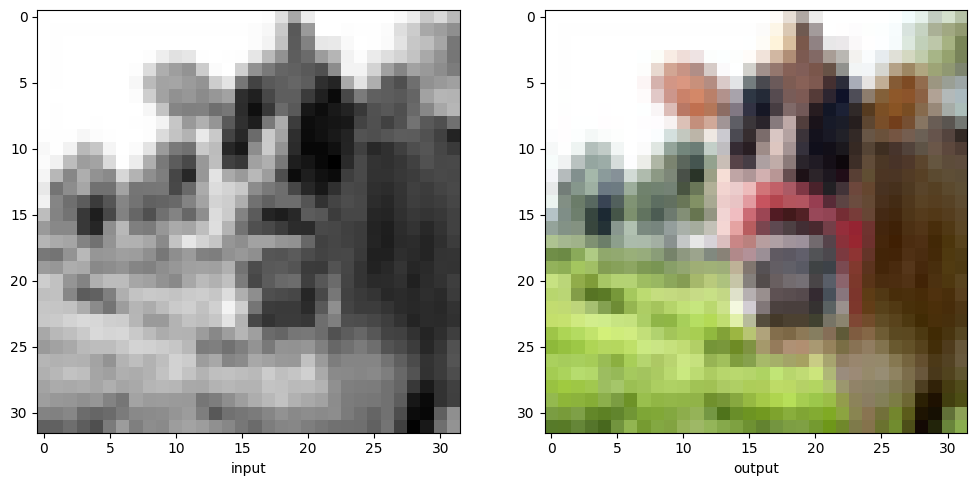

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(x_train[0].reshape(32, 32), cmap='gray')
ax2.imshow(y_train[0])
ax1.set_xlabel('input')
ax2.set_xlabel('output')
plt.show()

In [4]:
early_stopping = EarlyStopping(monitor='loss', patience=3)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1)
optimizer = Adam(learning_rate=0.01)

def fit_models(models):
  for model in models:
    print(f'--- {model.name} ---')
    model.compile(optimizer=optimizer, loss='mse')
    model.history = model.fit(
      x_train, y_train, epochs=20, batch_size=128,
      validation_data=(x_test, y_test),
      callbacks=[reduce_lr, early_stopping])

def plot_training(models, params):
  fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
  labels = [x.name for x in models]
  for ax, param in zip(axs.reshape(-1), params):
    for model in models:
      ax.plot(model.history.history[param])
    ax.set_ylabel(param)
    ax.set_xlabel('epoch')
    ax.legend(labels, loc='upper right')
  plt.show()

In [6]:
class BaseModel(Model):
  def __init__(self, name: str, layers: Iterable):
    super().__init__(name=name)
    self.__layers = tuple(layers)

  def call(self, x):
    return pipe(*self.__layers)(x)

class GrayscaleEncoder(BaseModel):
  def __init__(self, filters, kernel, dropout, normalize):
    super().__init__(name='GrayscaleEncoder', layers=self.__gen_layers(filters, kernel, dropout, normalize))

  def __gen_layers(self, filters, kernel, dropout, normalize):
    for filter in filters:
      yield Conv2D(filters=filter, kernel_size=kernel, strides=2, activation='relu', padding='same')
      if normalize: yield BatchNormalization()
      if dropout: yield Dropout(dropout)

class RgbDecoder(BaseModel):
  def __init__(self, filters, kernel):
    super().__init__(name='RgbDecoder', layers=self.__gen_layers(filters, kernel))

  @classmethod
  def __gen_layers(cls, filters, kernel):
    for filter in filters:
      yield Conv2DTranspose(filters=filter, kernel_size=kernel, strides=2, activation='relu', padding='same')
    yield Conv2D(filters=3, kernel_size=kernel, activation='sigmoid', padding='same')

class ImageAutoencoder(BaseModel):
  def __init__(self, *, filters, kernel, dropout=0, normalize=False):
    super().__init__(
      name=f"ImageAutoencoder{dropout and f' dropout-{dropout}' or ''}{normalize and f' normalized' or ''}",
      layers=(
        GrayscaleEncoder(filters, kernel, dropout, normalize),
        RgbDecoder(reversed(filters), kernel)
      )
    )


In [7]:
filters = [64, 128, 256]
kernel = 3
models = [
  ImageAutoencoder(filters=filters, kernel=kernel),
  ImageAutoencoder(filters=filters, kernel=kernel, normalize=True),
  ImageAutoencoder(filters=filters, kernel=kernel, dropout=0.2),
  ImageAutoencoder(filters=filters, kernel=kernel, normalize=True, dropout=0.2),
]
fit_models(models)

--- ImageAutoencoder -------------
Epoch 1/20
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
391/391 [==============================] - 135s 342ms/step - loss: 0.0205 - val_loss: 0.0126 - lr: 0.0100
Epoch 2/20
391/391 [==============================] - 123s 315ms/step - loss: 0.0120 - val_loss: 0.0117 - lr: 0.0100
Epoch 3/20
391/391 [==============================] - 121s 310ms/step - loss: 0.0116 - val_loss: 0.0117 - lr: 0.0100
Epoch 4/20
391/391 [==============================] - 134s 342ms/step - loss: 0.0113 - val_loss: 0.0114 - lr: 0.0100
Epoch 5/20
391/391 [==============================] - 129s 330ms/step - loss: 0.0109 - val_loss: 0.0107 - lr: 0.0100
Epoch 6/20
391/391 [==============================] - 118s 303ms/step - loss: 0.0106 - val_loss: 0.0105 - 

ValueError: in user code:

    File "C:\Users\HououinKyouma\PycharmProjects\eio-2022\venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\HououinKyouma\PycharmProjects\eio-2022\venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HououinKyouma\PycharmProjects\eio-2022\venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\HououinKyouma\PycharmProjects\eio-2022\venv\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\HououinKyouma\PycharmProjects\eio-2022\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Hououin Kyouma\AppData\Local\Programs\Python\Python310\lib\contextlib.py", line 492, in enter_context
        result = _cm_type.__enter__(cm)
    File "C:\Users\Hououin Kyouma\AppData\Local\Programs\Python\Python310\lib\contextlib.py", line 135, in __enter__
        return next(self.gen)

    ValueError: 'ImageAutoencoder normalized/' is not a valid root scope name. A root scope name has to match the following pattern: ^[A-Za-z0-9.][A-Za-z0-9_.\\/>-]*$


KeyError: 'loss'

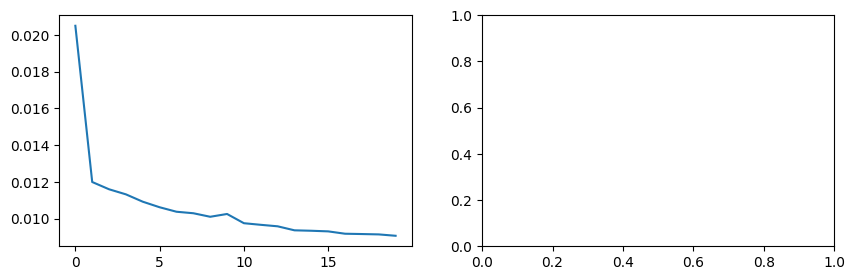

In [8]:
plot_training(models, params=['loss', 'val_loss'])


In [9]:
Y_test = models[0].predict(x_test[:100, :, :, :])
print(Y_test.shape)

4/4 [==============================] - 0s 21ms/step
(100, 32, 32, 3)


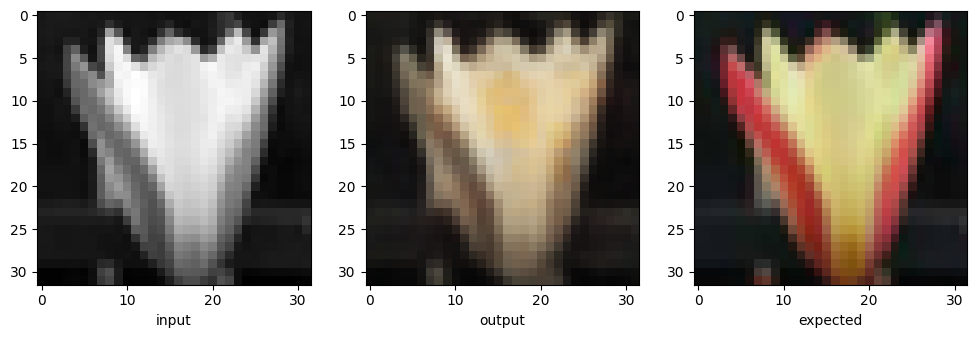

In [10]:
def plot_result(x, y, Y):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
  ax1.imshow(x.reshape(x.shape[0], x.shape[1]), cmap='gray')
  ax2.imshow(Y)
  ax3.imshow(y)
  ax1.set_xlabel('input')
  ax2.set_xlabel('output')
  ax3.set_xlabel('expected')

def plot_test_result(index):
  plot_result(x_test[index], y_test[index], Y_test[index])

plot_test_result(16)

1/1 [==============================] - 0s 279ms/step


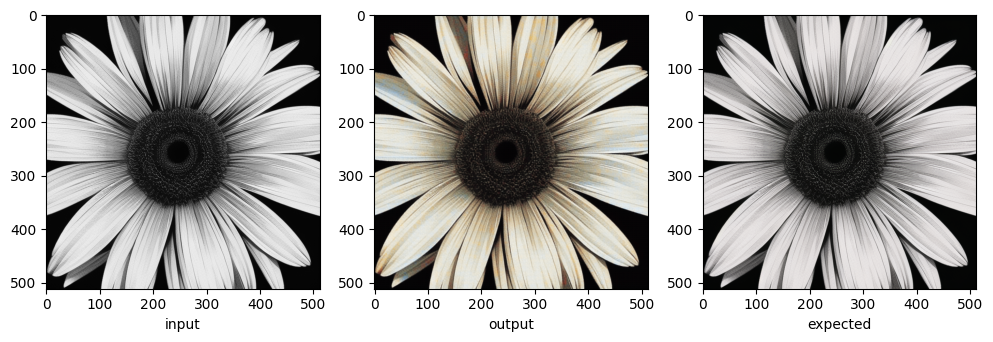

In [11]:
def color_image_from_path(model, path):
  y = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB).astype('float32') / 255
  x = cv.cvtColor(y, cv.COLOR_RGB2GRAY)
  y_result = model.predict(x.reshape(1, x.shape[0], x.shape[1], 1))[0]
  plot_result(x, y, y_result)

color_image_from_path(models[0], 'resources/novelai-flower-1.png')

In [16]:
models[0].save_weights("models/model.ckpt")